In [30]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz
from graphviz import Source


#open CSV using pandas (treated as initalization)
df = pd.read_csv(r"C:\Users\braxm\Downloads\anomaliesFile.csv")
display(df)
# CONVERSIONS 


#protocols
dict = {'TPLINK-SMARTHOME/JSON': 0, 'DNS': 0, 'MDNS': 0, 'HTTP': 0, 'RCL': 0, 
        'TLS': 0, 'TLSv1.2': 0, 'TLSv1.3': 0, 'AJP13': 0, 'SSDP': 0, 'ICMP': 0, 'ICMPv6': 0, 
        'LLMNR': 0, 'BROWSER': 0 , 'NTP': 0, 'IGMPv3': 0,
        'DHCP': 0, 'RSL': 0, 'SSH': 2, 'SSHv2': 2, 'TCP': 1}

df['Protocol'] = df['Protocol'].map(dict)


#information
       
#encode_info function will convert all string attributes to binary values where 1 signifies a probable anomaly, 0 otherwise
#mainly focused on anomalies on TCP and SSH packets

def encode_info():
    j = 0
    limit = 0
    for j, row in df.iterrows():
        if('RST' in df['Info'][j] or 'Retransmission' in df['Info'][j] or 'TCP Port numbers reused' in df['Info'][j]):
            df.loc[j, 'Info'] = '1' #anomaly
        elif((df['Info'][j] == "Client: New Keys")):
            df.loc[j, 'Info'] = '0' #benign
            limit+=1
        elif(limit == 3 and (df["Info"][j]=="Client: " or df["Info"][j] == "Server: ")):
            df.loc[j, 'Info'] = '1' #anomaly      
        else:
            df.loc[j, 'Info'] = '0' #benign
    return df['Info'].astype(int)

df['Info'] = encode_info()

#classifier 
df['Classifier'] = df['Info']

unique_sources = df['Source'].unique()
display(unique_sources)

# mode column

#groups unique IP addresses together
grouped = df.groupby('Source')

#counts 1s and 0s based on classifier column using unique IPs stored in group
goodSrc_count = grouped['Classifier'].apply(lambda x: (x==0).sum())
badSrc_count = grouped['Classifier'].apply(lambda x: (x!=0).sum())

#assign value for final
final_value = (goodSrc_count <= badSrc_count).astype(int)

#map final to rows for proper addresses
df['Final'] = df['Source'].map(final_value)


#IP address conversion
ipSRC_encoder = LabelEncoder()
ipDEST_encoder = LabelEncoder()
df['Source'] = ipSRC_encoder.fit_transform(df['Source'])
df['Destination'] = ipDEST_encoder.fit_transform(df['Destination'])

display(df)


#assign features and target
features = ['Source','Destination', 'Info', 'Protocol', 'Classifier']
target = ['Final']
X = df[features]
y = df[target]
display(X,y)


,No.,Time,Source,Destination,Protocol,Info
0,1,13:53.1,192.168.99.5,199.111.115.11,DNS,Standard query 0x076a AAAA connectivity-check....
1,2,13:53.2,199.111.115.11,192.168.99.5,DNS,Standard query response 0x076a AAAA connectivi...
2,3,13:54.7,192.168.99.7,239.255.255.250,SSDP,M-SEARCH * HTTP/1.1
3,4,13:55.7,192.168.99.7,239.255.255.250,SSDP,M-SEARCH * HTTP/1.1
4,5,13:56.7,192.168.99.7,239.255.255.250,SSDP,M-SEARCH * HTTP/1.1
...,...,...,...,...,...,...
1636,3099,50:05.8,192.168.99.7,224.0.0.251,MDNS,Standard query 0x0000 PTR _googlecast._tcp.loc...
1637,3101,50:10.0,192.168.99.5,185.125.190.57,NTP,"NTP Version 4, client"
1638,3102,50:10.1,185.125.190.57,192.168.99.5,NTP,"NTP Version 4, server"
1639,3105,50:29.2,192.168.99.5,192.168.99.255,BROWSER,"Local Master Announcement UBUNTU1, Workstation..."


array(['192.168.99.5', '199.111.115.11', '192.168.99.7', '192.168.99.2',
       '192.168.99.6', '185.125.190.56', '185.125.190.57', '192.168.99.3',
       '185.125.190.17'], dtype=object)

,No.,Time,Source,Destination,Protocol,Info,Classifier,Final
0,1,13:53.1,5,9,0,0,0,1
1,2,13:53.2,8,7,0,0,0,0
2,3,13:54.7,7,13,0,0,0,0
3,4,13:55.7,7,13,0,0,0,0
4,5,13:56.7,7,13,0,0,0,0
...,...,...,...,...,...,...,...,...
1636,3099,50:05.8,7,11,0,0,0,0
1637,3101,50:10.0,5,3,0,0,0,1
1638,3102,50:10.1,2,7,0,0,0,0
1639,3105,50:29.2,5,5,0,0,0,1


,Source,Destination,Info,Protocol,Classifier
0,5,9,0,0,0
1,8,7,0,0,0
2,7,13,0,0,0
3,7,13,0,0,0
4,7,13,0,0,0
...,...,...,...,...,...
1636,7,11,0,0,0
1637,5,3,0,0,0
1638,2,7,0,0,0
1639,5,5,0,0,0


,Final
0,1
1,0
2,0
3,0
4,0
...,...
1636,0
1637,1
1638,0
1639,1


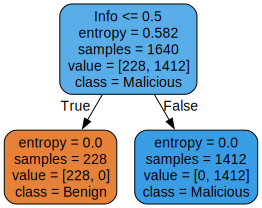

In [31]:
#model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state=42)


dT = DecisionTreeClassifier(criterion='entropy')
dT = dT.fit(X_train,y_train)

names = ['Benign','Malicious']

with open("netTreeEnt.dot") as f:
    dot_graph = f.read()
Source(dot_graph) 



In [32]:
ben_IPs = set()
sus_IPs = set()

# Loop through each row in the DataFrame
for a, row in df.iterrows():
    # Extract the features for prediction
    yyy = df.loc[a, features]
    res = pd.DataFrame([yyy])
    X = dT.predict(res)
    current_ip = row['Source']
    # Decode the IP address
    decoded_ip = ipSRC_encoder.inverse_transform([current_ip])[0]
    
    # Categorize the IP based on the model's prediction
    if X == 1:
        # If the prediction is 1, add to sus_IPs
        sus_IPs.add(decoded_ip)
    else:
        # Otherwise, add to ben_IPs only if it hasn't been flagged as suspicious before
        if decoded_ip not in sus_IPs:
            ben_IPs.add(decoded_ip)

# Convert the sets to lists
sus_IPs_list = list(sus_IPs)
ben_IPs_list = list(ben_IPs)

# Display the lists
print("Benign IPs:", ben_IPs_list)
print("Suspicious IPs:", sus_IPs_list)

Benign IPs: ['185.125.190.56', '185.125.190.57', '199.111.115.11', '192.168.99.7', '192.168.99.3', '192.168.99.2', '185.125.190.17']
Suspicious IPs: ['192.168.99.6', '192.168.99.5']
